# Importing Libraries

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import warnings as ws
ws.filterwarnings('ignore')

# Data Sourcing
Our data source appears to be private, as it is associated with a specific organization.

In [5]:
#Loading the file into dataframe
df=pd.read_csv('../Data_Source/loan.csv')

In [189]:
#Checking the number of columns and rows it has
df.shape

(39717, 111)

In [218]:
# Check how many columns have 100% Null values
100*df.isnull().mean()[df.isnull().mean()==1]

mths_since_last_major_derog       100.0
annual_inc_joint                  100.0
dti_joint                         100.0
verification_status_joint         100.0
tot_coll_amt                      100.0
tot_cur_bal                       100.0
open_acc_6m                       100.0
open_il_6m                        100.0
open_il_12m                       100.0
open_il_24m                       100.0
mths_since_rcnt_il                100.0
total_bal_il                      100.0
il_util                           100.0
open_rv_12m                       100.0
open_rv_24m                       100.0
max_bal_bc                        100.0
all_util                          100.0
total_rev_hi_lim                  100.0
inq_fi                            100.0
total_cu_tl                       100.0
inq_last_12m                      100.0
acc_open_past_24mths              100.0
avg_cur_bal                       100.0
bc_open_to_buy                    100.0
bc_util                           100.0


In [219]:
#Identify the columns which are totally empty
empty_column=df.isnull().mean()[100*df.isnull().mean()==100].keys()
empty_column

Index(['mths_since_last_major_derog', 'annual_inc_joint', 'dti_joint',
       'verification_status_joint', 'tot_coll_amt', 'tot_cur_bal',
       'open_acc_6m', 'open_il_6m', 'open_il_12m', 'open_il_24m',
       'mths_since_rcnt_il', 'total_bal_il', 'il_util', 'open_rv_12m',
       'open_rv_24m', 'max_bal_bc', 'all_util', 'total_rev_hi_lim', 'inq_fi',
       'total_cu_tl', 'inq_last_12m', 'acc_open_past_24mths', 'avg_cur_bal',
       'bc_open_to_buy', 'bc_util', 'mo_sin_old_il_acct',
       'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl',
       'mort_acc', 'mths_since_recent_bc', 'mths_since_recent_bc_dlq',
       'mths_since_recent_inq', 'mths_since_recent_revol_delinq',
       'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl',
       'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl',
       'num_rev_accts', 'num_rev_tl_bal_gt_0', 'num_sats', 'num_tl_120dpd_2m',
       'num_tl_30dpd', 'num_tl_90g_dpd_24m', 'num_tl_op_past_12m',
       'pct_tl_nvr_dl

In [220]:
#Drop the column which are completely empty
df1=df.drop(columns=empty_column)

In [221]:
df1.shape

(39717, 57)

In [222]:
100*df1.isnull().mean().sort_values(ascending=False)

next_pymnt_d                  97.129693
mths_since_last_record        92.985372
mths_since_last_delinq        64.662487
desc                          32.580507
emp_title                      6.191303
emp_length                     2.706650
pub_rec_bankruptcies           1.754916
last_pymnt_d                   0.178765
chargeoff_within_12_mths       0.140998
collections_12_mths_ex_med     0.140998
revol_util                     0.125891
tax_liens                      0.098195
title                          0.027696
last_credit_pull_d             0.005036
home_ownership                 0.000000
int_rate                       0.000000
out_prncp_inv                  0.000000
total_pymnt                    0.000000
total_pymnt_inv                0.000000
total_rec_prncp                0.000000
total_rec_int                  0.000000
total_rec_late_fee             0.000000
recoveries                     0.000000
collection_recovery_fee        0.000000
term                           0.000000


In [223]:
#Column next_pymnt_d and mths_since_last_record has > 90% null values
df1=df1.drop(columns=[])

In [224]:
#Check if any rows are totally empty
100*df1.isnull().mean(axis=1).sort_values(ascending=False)

39660    14.035088
39659    14.035088
39715    12.280702
39714    12.280702
39650    12.280702
           ...    
11439     0.000000
12717     0.000000
9898      0.000000
656       0.000000
13631     0.000000
Length: 39717, dtype: float64

In [225]:
#Check if duplicate records are there 
df1.drop_duplicates().shape

(39717, 57)

In [226]:
#Identify numeric and string column
num_col=df1.dtypes[(df1.dtypes=='int64') | (df1.dtypes=='float64')]
str_col=df1.dtypes[~((df1.dtypes=='int64') | (df1.dtypes=='float64'))]

In [227]:
#Remove % sign from int_rate, revol_util
df1['int_rate']=df1['int_rate'].apply(lambda x: x.replace('%',''))
#df1['revol_util']=df1['revol_util'].apply(lambda x: x.replace('%',''))
#Remove xx from zip_code
df1['zip_code']=df1['zip_code'].apply(lambda x: x.replace('xx',''))
#Convert it into number
df1['zip_code']=pd.to_numeric(df1['zip_code'])
#Removing grade from subgrade so that only sub_grade will remain
df1['sub_grade']=df1['sub_grade'].apply(lambda x: x[-1])
#Remove % from revol_util
df1['revol_util']=df1['revol_util'].apply(lambda x: np.nan if pd.isna(x) else x.replace('%',''))
#Convert the value to float
df1['int_rate']=df1['int_rate'].str.strip().astype(float)
#Convert the value to float
df1['revol_util']=df1['revol_util'].str.strip().astype(float)

In [228]:
str_col.keys()

Index(['term', 'int_rate', 'grade', 'sub_grade', 'emp_title', 'emp_length',
       'home_ownership', 'verification_status', 'issue_d', 'loan_status',
       'pymnt_plan', 'url', 'desc', 'purpose', 'title', 'zip_code',
       'addr_state', 'earliest_cr_line', 'revol_util', 'initial_list_status',
       'last_pymnt_d', 'next_pymnt_d', 'last_credit_pull_d',
       'application_type'],
      dtype='object')

In [229]:
#drop not relevant columns 
#application_type has only 0.,Nan values hence need delete 
df1=df1.drop(columns=['mths_since_last_record','next_pymnt_d','application_type'
                      ,'collections_12_mths_ex_med'
                      ,'url','chargeoff_within_12_mths','tax_liens'
                      ,'delinq_amnt','acc_now_delinq','policy_code'
                      ,'pymnt_plan','initial_list_status'])

In [230]:
df1.shape

(39717, 45)

In [231]:
df1.columns

Index(['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv',
       'term', 'int_rate', 'installment', 'grade', 'sub_grade', 'emp_title',
       'emp_length', 'home_ownership', 'annual_inc', 'verification_status',
       'issue_d', 'loan_status', 'desc', 'purpose', 'title', 'zip_code',
       'addr_state', 'dti', 'delinq_2yrs', 'earliest_cr_line',
       'inq_last_6mths', 'mths_since_last_delinq', 'open_acc', 'pub_rec',
       'revol_bal', 'revol_util', 'total_acc', 'out_prncp', 'out_prncp_inv',
       'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int',
       'total_rec_late_fee', 'recoveries', 'collection_recovery_fee',
       'last_pymnt_d', 'last_pymnt_amnt', 'last_credit_pull_d',
       'pub_rec_bankruptcies'],
      dtype='object')

In [337]:
df2=df1
#Imputing UNKNOWNXXX where there are nulls
df2['title']=df1['title'].fillna('UNKNOWNXXX')

#wherever there are words like 'debt consolidation' replacing them with single value Debt Consolidation
#df2[df1['title'].str.contains('debt consolidation',case=False)]['title']='Debt Consolidation'
df2[df2['title'].str.contains('debt consolidation',case=False)]['title'].value_counts()

Debt Consolidation    6987
Name: title, dtype: int64

In [360]:
#Personal Loan
df2.loc[df2['title'].str.contains('personal loan',case=False),'title']='Personal Loan'

#Streamlining the values of title column where there are these two words Debt Consolidation it needs to be replaced with Debt Consolidation
df2.loc[df2['title'].str.contains('Debt Consolidation',case=False),'title']='Debt Consolidation'
df2.loc[df2['title'].str.contains('Consolidate Debt',case=False),'title']='Debt Consolidation'
df2.loc[df2['title'].str.contains('Consolidation Loan',case=False),'title']='Debt Consolidation'
df2.loc[df2['title'].str.contains('debt_consolidation',case=False),'title']='Debt Consolidation'
df2.loc[df2['title'].str.contains('Debt Payoff',case=False),'title']='Debt Consolidation'
df2.loc[df2['title'].str.contains('Dept Consolidation',case=False),'title']='Debt Consolidation'
df2.loc[df2['title'].str.contains('Loan Consolidation',case=False),'title']='Debt Consolidation'
df2.loc[df2['title'].str.contains('credit consolidation',case=False),'title']='Debt Consolidation'

#Streamlining the values of title column where there are these words Debt Consolidation it needs to be replaced with 'Credit Card Loan'
df2.loc[df2['title'].str.contains('credit card loan',case=False),'title']='Credit Card Loan'
df2.loc[df2['title'].str.contains('Credit Card Payoff',case=False,regex=True),'title']='Credit Card Loan'
df2.loc[df2['title'].str.contains(r'\b(?:credit.*card.*debt)\b',case=False,regex=True),'title']='Credit Card Loan'
df2.loc[df2['title'].str.contains('CC Consolidation',case=False),'title']='Credit Card Loan'
df2.loc[df2['title'].str.contains('Credit Card Consolidation',case=False),'title']='Credit Card Loan'
df2.loc[df2['title'].str.contains('Credit Card Refinance',case=False),'title']='Credit Card Loan'
df2.loc[df2['title'].str.contains('cc payoff',case=False),'title']='Credit Card Loan'
df2.loc[df2['title'].str.contains('Payoff Credit Cards',case=False),'title']='Credit Card Loan'

#Streamlining the values of title column where there are these words personal loan it needs to be replaced with 'Personal Loan'


df2.loc[df2['title'].str.contains(r'\b(?:credit.*card.*consolidation)\b',case=False,regex=True),'title']='Credit Card Consolidation'


df2.loc[df2['title'].str.lower()=='debt','title']='Debt'
#Check Count after replacing values
df2['title'].value_counts().head(50)

Debt Consolidation       7151
Credit Card Loan         2108
Personal Loan            1281
Consolidation             517
Home Improvement          356
Small Business Loan       328
Personal                  308
Home Improvement Loan     247
personal                  220
Loan                      213
Wedding Loan              208
consolidation             205
Car Loan                  204
Other Loan                191
Wedding                   154
Major Purchase Loan       145
Debt                      145
Consolidate               126
Medical                   122
Credit Card               118
home improvement          111
My Loan                    93
Credit Cards               93
loan                       84
Business Loan              82
Freedom                    81
Moving Loan                76
consolidate                73
Motorcycle                 65
Debt Loan                  62
Medical Loan               62
Major Purchase             60
Engagement Ring            59
Home impro

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,last_credit_pull_d,pub_rec_bankruptcies


In [188]:
#Seggrigation of column 
ordered_cat=['term','grade','sub_grade','emp_length','issue_d','delinq_2yrs'
             ,'earliest_cr_line','inq_last_6mths','mths_since_last_delinq',
             'last_pymnt_d','last_credit_pull_d','pub_rec_bankruptcies']
unordered_cat=['home_ownership','verification_status','loan_status','purpose',
               'zip_code','addr_state','emp_title','title']
other=['id','member_id','desc']
measure_col=['loan_amnt', 'funded_amnt','funded_amnt_inv','int_rate',
             'installment','annual_inc','dti','open_acc','pub_rec','revol_bal'
             ,'revol_util','total_acc','out_prncp','total_pymnt'
             ,'total_pymnt_inv','total_rec_prncp','total_rec_int','total_rec_late_fee'
             ,'recoveries','collection_recovery_fee','last_pymnt_amnt']
df1['pub_rec_bankruptcies'].unique()

array([ 0.,  1.,  2., nan])

# Unordered Categorical Variables - Univariate Analysis
### Power Law Distribution

In [375]:
df1_bad=df1[df1['loan_status']=='Charged Off']
df1_good=df1[df1['loan_status']=='Fully Paid']


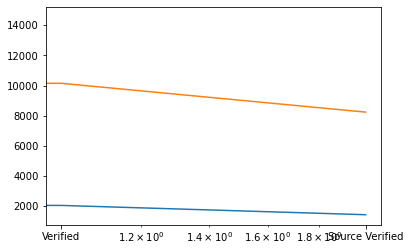

In [65]:
df1_d=df1[df1['loan_status']=='Charged Off']
df1_f=df1[df1['loan_status']=='Fully Paid']
plt.xscale("log")
plt.plot(df1_d['verification_status'].value_counts())
plt.plot(df1_f['verification_status'].value_counts())
plt.show()

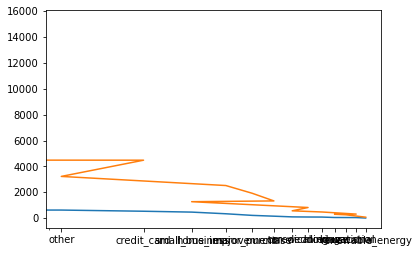

In [72]:
df1_d['purpose'].value_counts(),df1_f['purpose'].value_counts()
df1_d=df1[df1['loan_status']=='Charged Off']
df1_f=df1[df1['loan_status']=='Fully Paid']
plt.xscale("log")
plt.plot(df1_d['purpose'].value_counts())
plt.plot(df1_f['purpose'].value_counts())
plt.show()

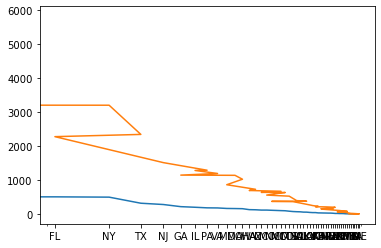

In [374]:
df1_d=df1[df1['loan_status']=='Charged Off']
df1_f=df1[df1['loan_status']=='Fully Paid']
plt.xscale("log")
plt.plot(df1_d['addr_state'].value_counts())
plt.plot(df1_f['addr_state'].value_counts())
plt.show()



# Bar Graph for Unordered Categorical Variable

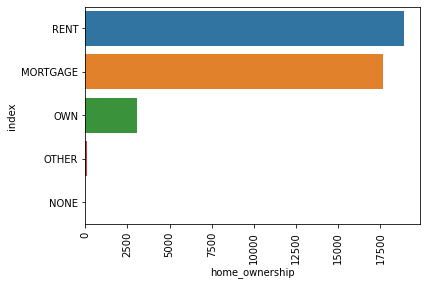

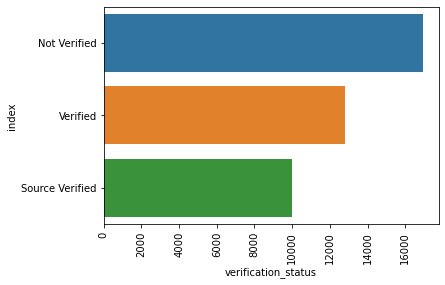

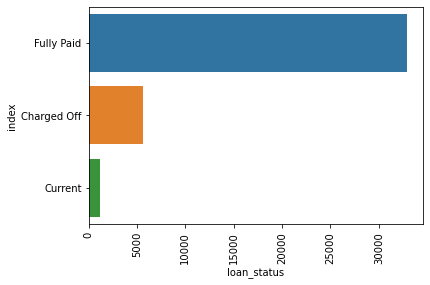

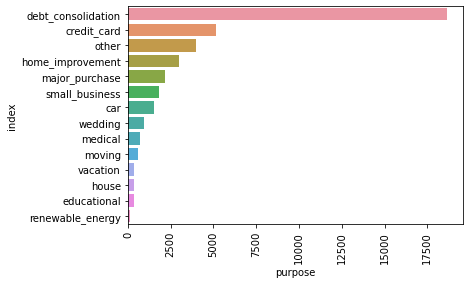

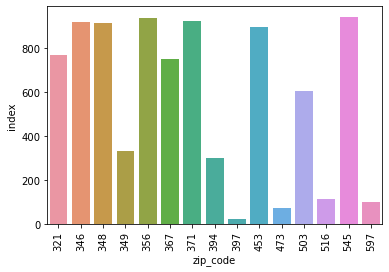

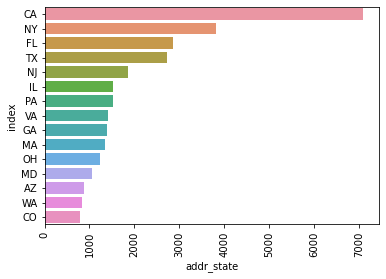

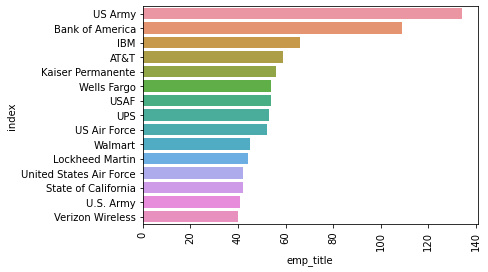

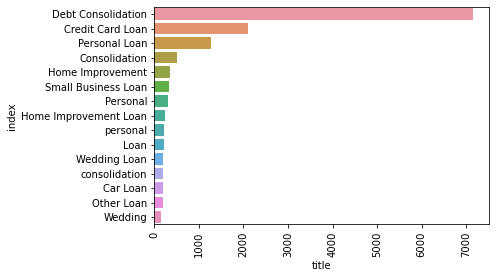

In [380]:
for z in unordered_cat:
    dta=df1[z].value_counts().head(15).reset_index()
    sns.barplot(y='index',x=z,data=dta)
    plt.xticks(rotation=90)
    plt.show()

# Ordered Categorical Variables - Univariate Analysis

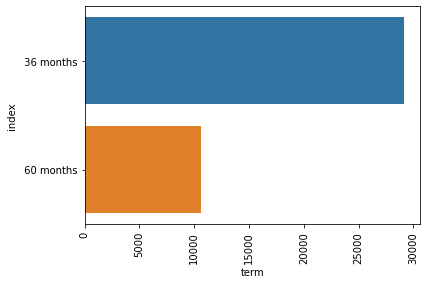

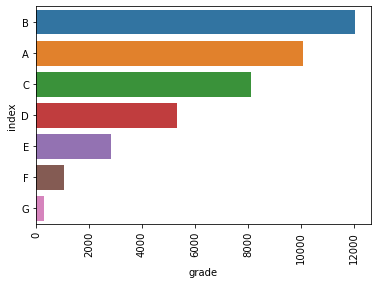

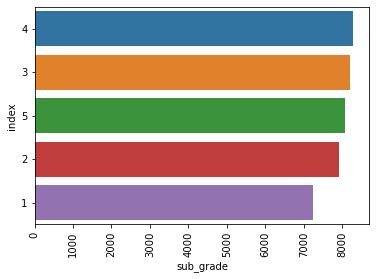

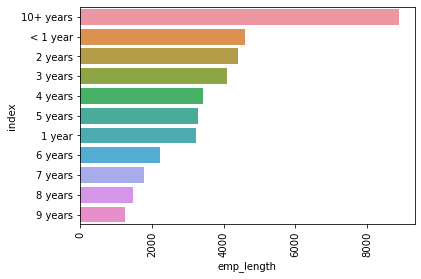

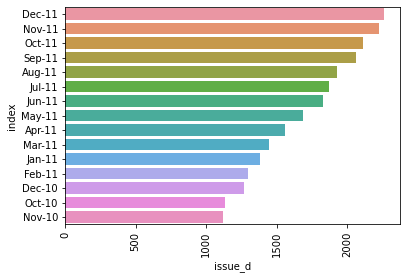

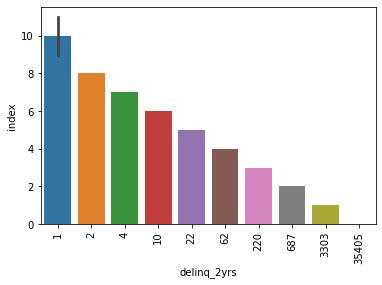

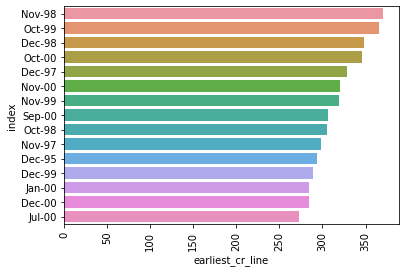

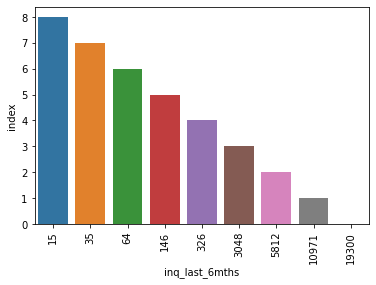

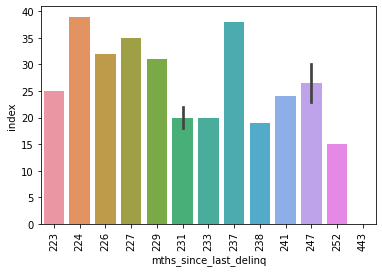

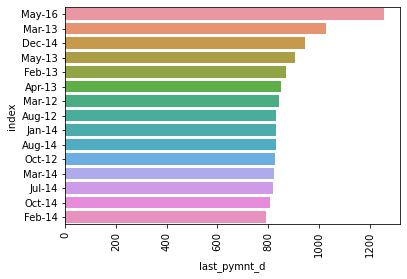

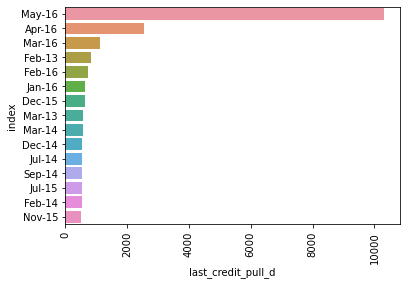

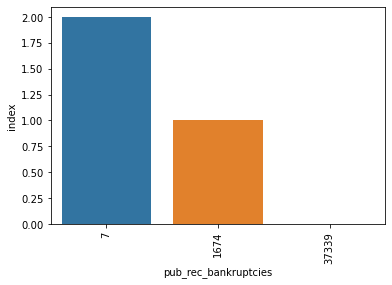

In [381]:
for z in ordered_cat:
    dta=df1[z].value_counts().head(15).reset_index()
    sns.barplot(y='index',x=z,data=dta)
    plt.xticks(rotation=90)
    plt.show()

# Segmentation/ Multivariate 

sns.countplot(data=df1,x='loan_status',hue='home_ownership')

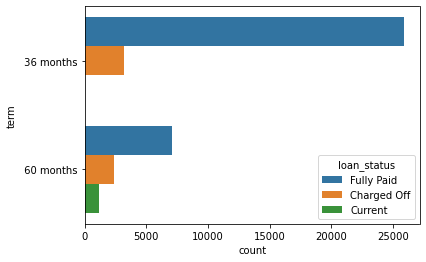

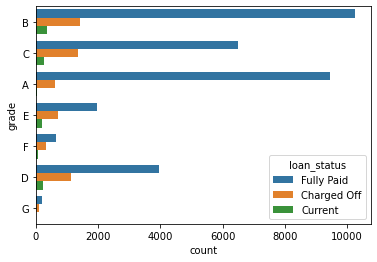

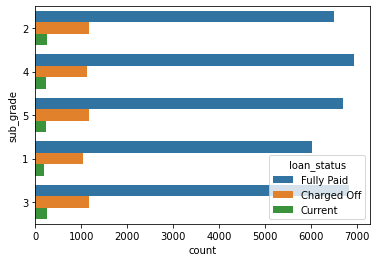

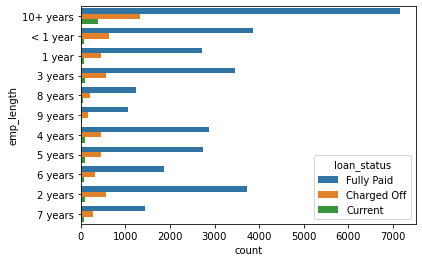

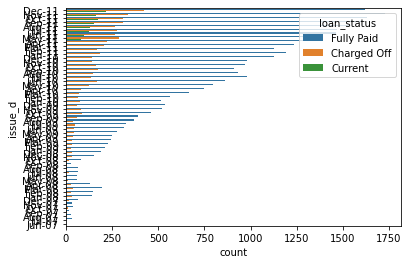

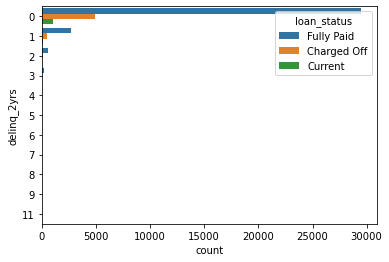

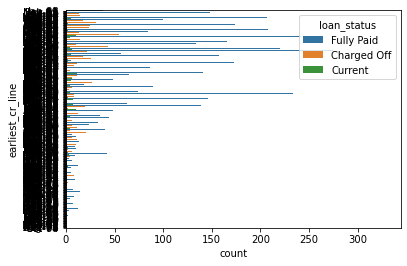

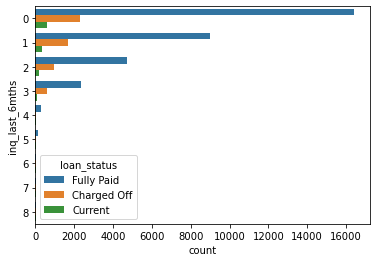

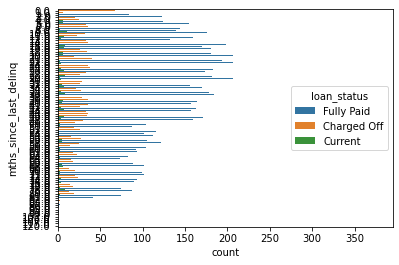

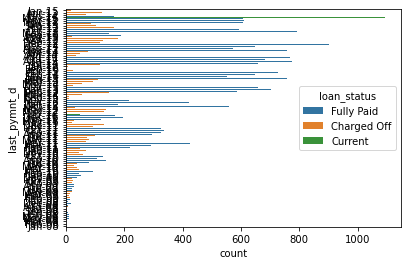

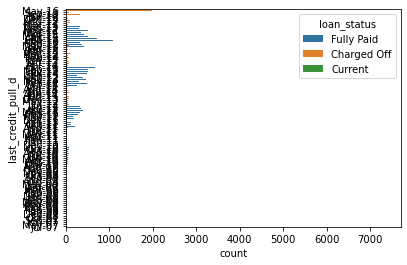

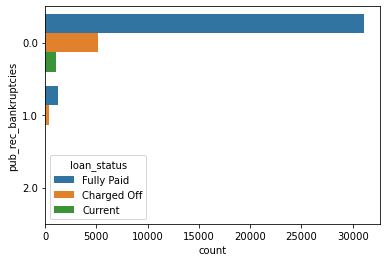

In [390]:
for z in ordered_cat:
    sns.countplot(data=df1,hue='loan_status',y=z)
    plt.show()

# Identifying Outliers

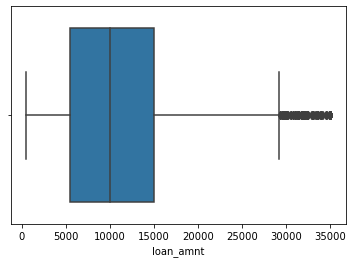

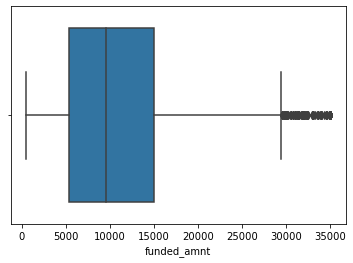

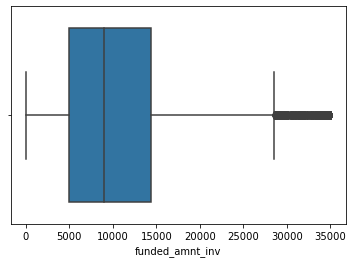

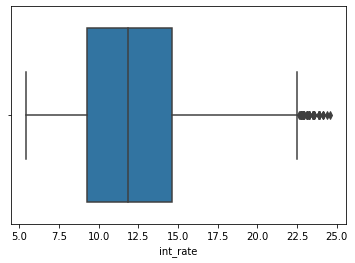

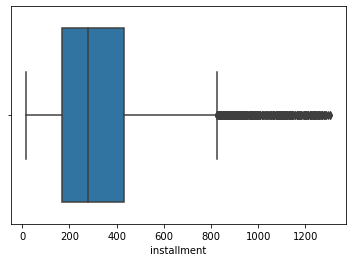

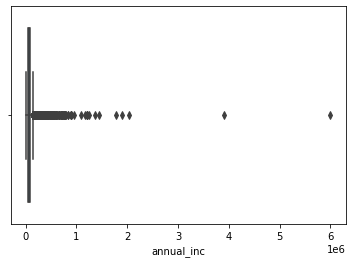

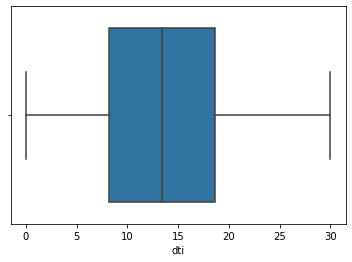

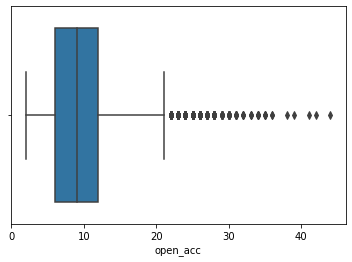

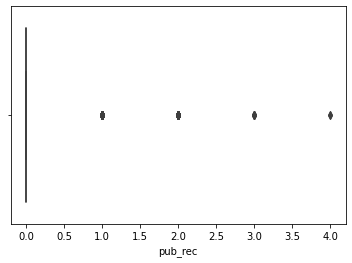

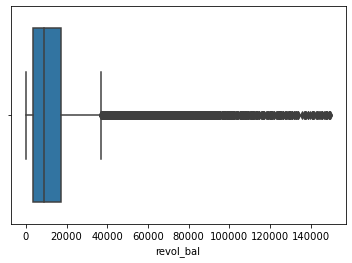

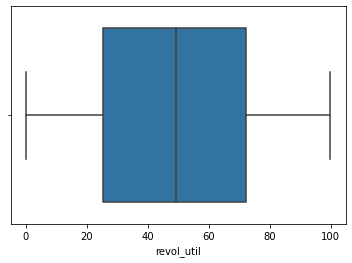

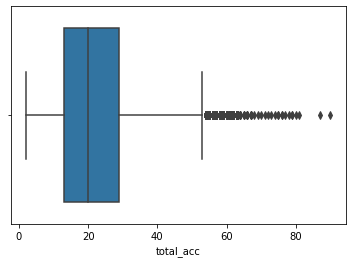

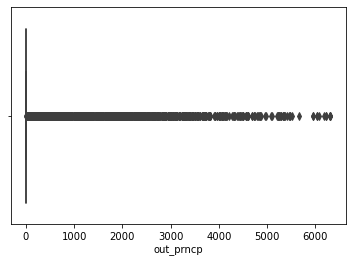

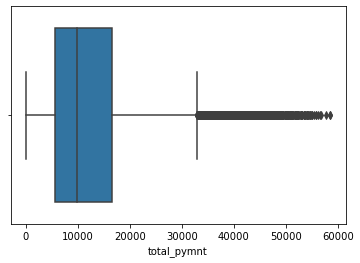

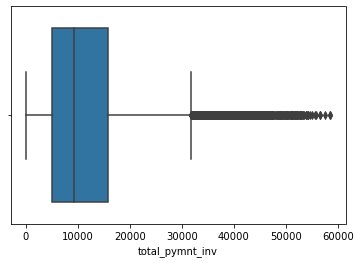

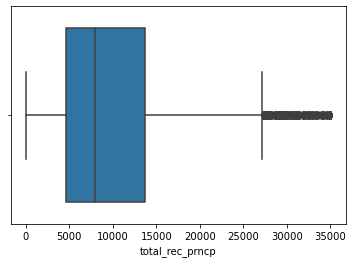

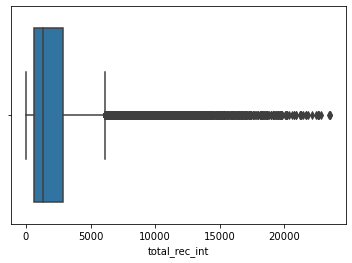

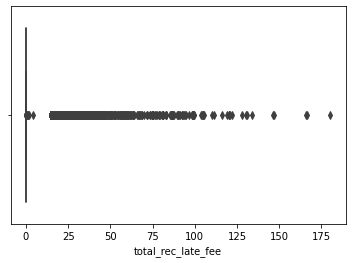

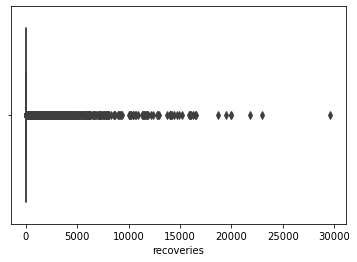

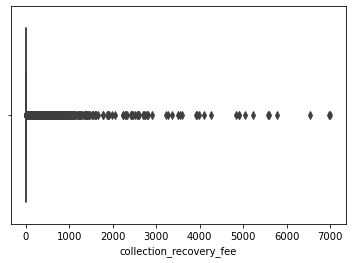

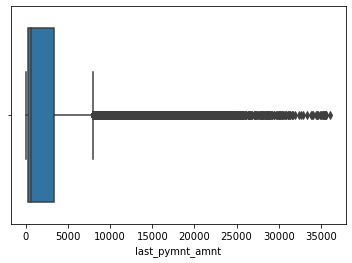

In [421]:
for z in measure_col:
    sns.boxplot(df1[z])
    plt.show()



In [75]:
corr_ho_ls=df1_d['home_ownership'].value_counts().reset_index()
corr_ho_ls.rename(columns={'home_ownership':'Charged_Off'},inplace=True)
corr_ho_ls_1=df1_f['home_ownership'].value_counts().reset_index()
corr_ho_ls_1.rename(columns={'home_ownership':'Fully_Paid'},inplace=True)
corr_ho_ls=corr_ho_ls.merge(corr_ho_ls_1,how='left',on='index')
corr_ho_ls[['Charged_Off','Fully_Paid']].corr()

,Charged_Off,Fully_Paid
Charged_Off,1.000000,0.994636
Fully_Paid,0.994636,1.000000


In [86]:
ordered_cat=['term','grade','sub_grade','emp_length','issue_d','delinq_2yrs'
             ,'earliest_cr_line','inq_last_6mths','mths_since_last_delinq',
             'last_pymnt_d','last_credit_pull_d','pub_rec_bankruptcies']
df1_d=df1[df1['loan_status']=='Charged Off']
df1_f=df1[df1['loan_status']=='Fully Paid']
#sns.barplot(df1_d['term'].value_counts().reset_index())
df1_d['term'].value_counts().reset_index()

,index,term
0,36 months,3227
1,60 months,2400


In [25]:
df1_d['issue_d'].value_counts()

Dec-11    423
Nov-11    335
Oct-11    308
Sep-11    307
May-11    289
Jul-11    278
Aug-11    267
Jun-11    267
Apr-11    221
Mar-11    207
Jan-11    186
Sep-10    175
Feb-11    168
Jun-10    166
Oct-10    160
Aug-10    148
Nov-10    142
Dec-10    142
Jul-10    137
May-10    125
Oct-09     87
Nov-09     83
Apr-10     82
Jan-10     76
Mar-10     69
Feb-10     63
Dec-09     62
Sep-09     57
Jul-09     47
Jun-09     43
May-09     42
Aug-09     40
Apr-09     40
Mar-08     40
Feb-09     34
Dec-08     33
Jan-08     31
Nov-08     31
Mar-09     31
Jan-09     28
Apr-08     27
Feb-08     25
Dec-07     18
Jul-08     17
Oct-08     15
May-08     10
Oct-07     10
Jun-08      7
Nov-07      7
Aug-07      7
Aug-08      6
Sep-08      5
Sep-07      3
Name: issue_d, dtype: int64

In [26]:
df1_f['issue_d'].value_counts()

Nov-11    1727
Oct-11    1633
Dec-11    1619
Sep-11    1606
Aug-11    1531
Jul-11    1467
Jun-11    1461
Apr-11    1338
May-11    1320
Mar-11    1235
Jan-11    1194
Feb-11    1129
Dec-10    1125
Jul-10     982
Nov-10     979
Oct-10     972
Aug-10     930
Sep-10     911
Jun-10     863
May-10     795
Apr-10     745
Mar-10     668
Feb-10     564
Dec-09     536
Nov-09     519
Jan-10     513
Oct-09     458
Sep-09     392
Aug-09     368
Jul-09     327
Jun-09     313
May-09     277
Apr-09     250
Mar-09     245
Feb-09     226
Jan-09     211
Mar-08     196
Dec-08     190
Nov-08     153
Feb-08     149
Jan-08     140
Apr-08     128
Oct-08      81
Dec-07      67
Jul-08      66
Aug-08      65
May-08      61
Jun-08      59
Oct-07      37
Nov-07      30
Jul-07      30
Sep-08      27
Aug-07      26
Sep-07      15
Jun-07       1
Name: issue_d, dtype: int64

In [30]:
#df1['sub_grade']=df1['sub_grade'].apply(lambda x: x[-1])



In [ ]:
df1.isnull().sum()[(df1.isnull().sum()>0)]

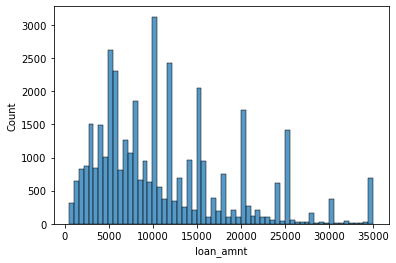

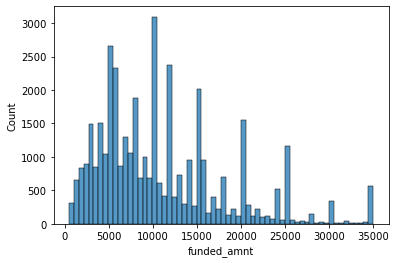

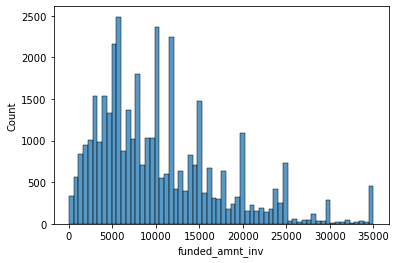

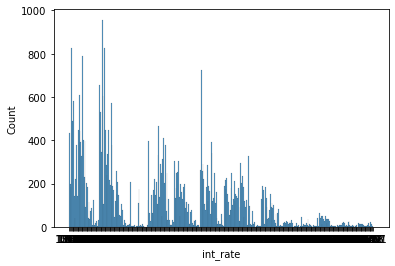

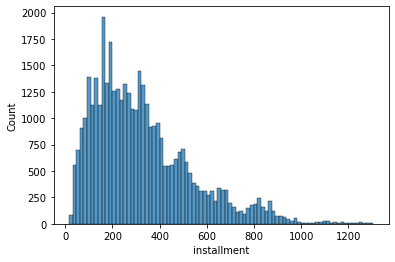

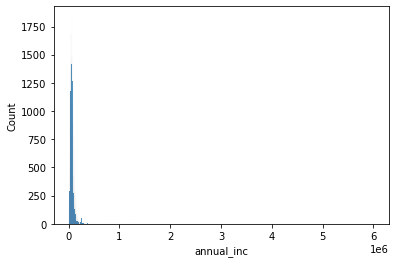

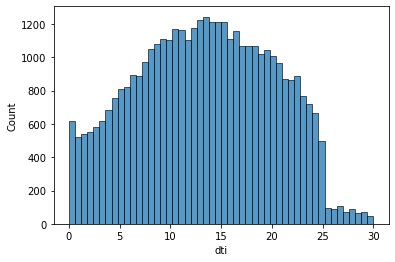

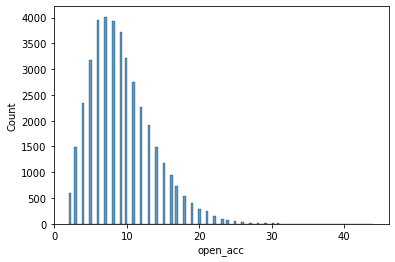

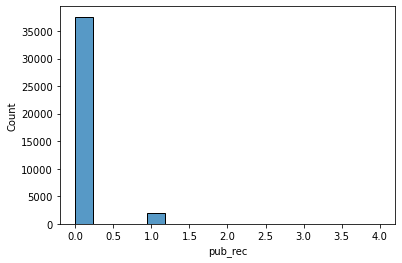

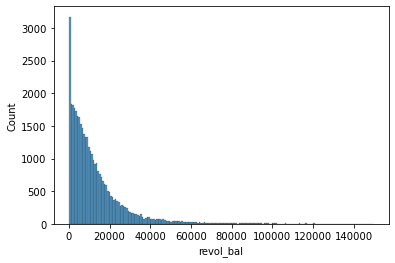

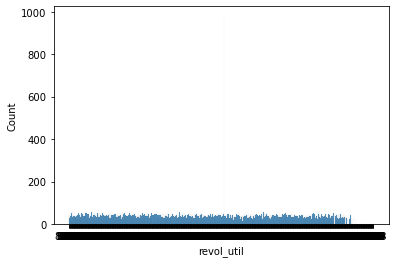

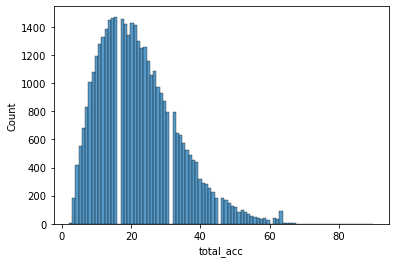

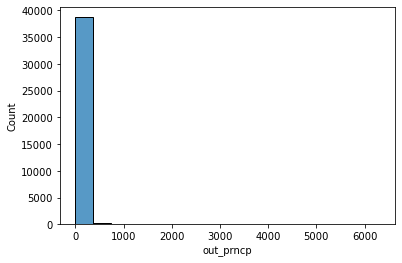

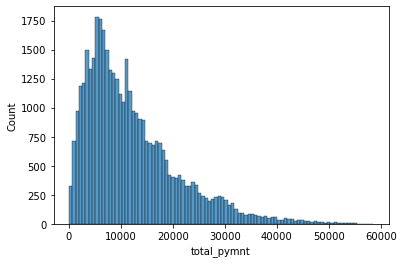

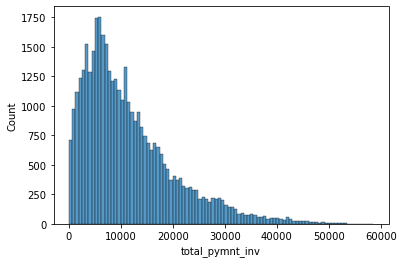

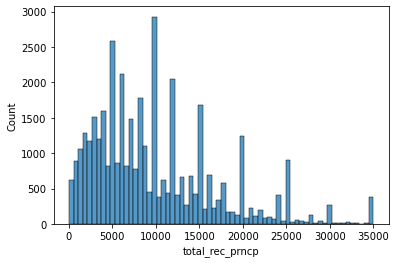

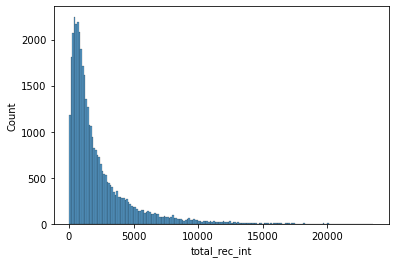

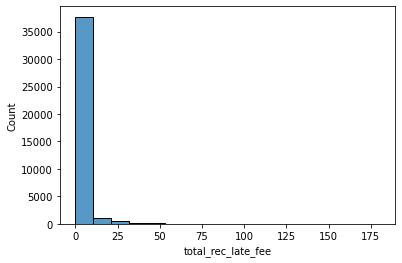

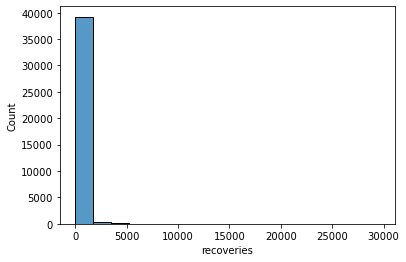

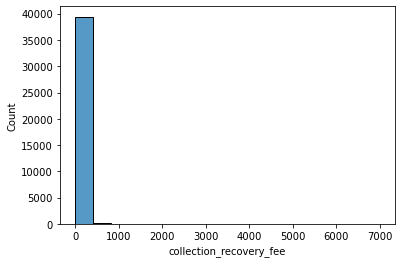

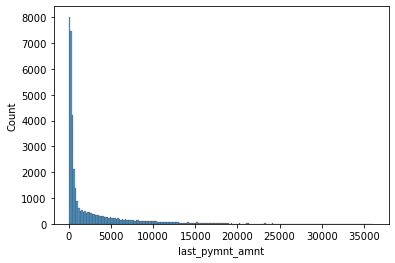

In [28]:
for i in measure_col:
    sns.histplot(df1[i])
    plt.show()